# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
import mne
import os


# Data Preparation

In [2]:

old = "old_results_all.csv"
young = "young_results_all.csv"
old_df = pd.read_csv(old)
young_df = pd.read_csv(young)

combined_df = pd.concat([old_df, young_df], ignore_index=True)

old_male_id = old_df[old_df['group'].str.contains('Male')]['subject_id'].unique()
old_female_id = old_df[old_df['group'].str.contains('Female')]['subject_id'].unique()

print(f"Number of old male participants: {len(old_male_id)}")
print(f"Number of old female participants: {len(old_female_id)}")




young_male_id = combined_df[(combined_df['age_group'] == 'young') & (combined_df['group'].str.contains('Male'))]['subject_id'].unique()
print(f"Number of young male participants: {len(young_male_id)}")

young_female_id = combined_df[(combined_df['age_group'] == 'young') & (combined_df['group'].str.contains('Female'))]['subject_id'].unique()
print(f"Number of young female participants: {len(young_female_id)}")

young_male_subjects = np.random.choice(young_male_id, size=18, replace=False)
young_female_subjects = np.random.choice(young_female_id, size=11, replace=False)

print(f"Old male subjects: {old_male_id}")
print(f"Old female subjects: {old_female_id}")
print(f"Young male subjects: {young_male_subjects}")
print(f"Young female subjects: {young_female_subjects}")

selected_young_subjects = np.concatenate([young_male_subjects, young_female_subjects])

print(f"Selected young subjects: {selected_young_subjects}")


# Create a new dataframe with the selected subjects both old and young
selected_subjects = np.concatenate([old_male_id, old_female_id, selected_young_subjects])
print("-" * 100)
print(f"Selected subjects: {selected_subjects}")
print(len(selected_subjects))

# Turn this into a dataframe
selected_subjects_df = pd.DataFrame(selected_subjects, columns=['subject_id'])
new_df = combined_df[combined_df['subject_id'].isin(selected_subjects)]

Number of old male participants: 19
Number of old female participants: 10
Number of young male participants: 28
Number of young female participants: 11
Old male subjects: ['sub-010290' 'sub-010276' 'sub-010081' 'sub-010246' 'sub-010089'
 'sub-010257' 'sub-010289' 'sub-010088' 'sub-010268' 'sub-010272'
 'sub-010286' 'sub-010092' 'sub-010284' 'sub-010283' 'sub-010251'
 'sub-010267' 'sub-010085' 'sub-010245' 'sub-010243']
Old female subjects: ['sub-010258' 'sub-010242' 'sub-010291' 'sub-010086' 'sub-010090'
 'sub-010250' 'sub-010249' 'sub-010247' 'sub-010277' 'sub-010244']
Young male subjects: ['sub-010227' 'sub-010067' 'sub-010310' 'sub-010263' 'sub-010292'
 'sub-010311' 'sub-010298' 'sub-010241' 'sub-010261' 'sub-010315'
 'sub-010053' 'sub-010300' 'sub-010318' 'sub-010303' 'sub-010317'
 'sub-010195' 'sub-010230' 'sub-010265']
Young female subjects: ['sub-010075' 'sub-010155' 'sub-010083' 'sub-010270' 'sub-010084'
 'sub-010157' 'sub-010166' 'sub-010064' 'sub-010164' 'sub-010165'
 'sub-01

## Normalize the power


The following code implements a subject-specific normalization approach:

1. **Create a working copy** of the original dataframe to preserve raw data
2. **Iterate through each subject** to handle individual differences
3. **Process each condition-band combination** separately for proper normalization context
4. **Calculate normalization factor** as the sum of power values across all regions
5. **Normalize region-specific power** by dividing by the total power

This approach ensures that power comparisons between regions account for individual 
differences in overall signal strength while maintaining the relative distribution 
across brain regions.

In [3]:
new_df_normalized = new_df.copy()
for subject in new_df['subject_id'].unique():
    subjectdf = new_df[new_df['subject_id'] == subject]

    for condition in subjectdf['condition'].unique():
        for band in subjectdf['band'].unique():
            normalizs = subjectdf[(subjectdf['condition'] == condition) & (subjectdf['band'] == band)]['power'].sum()
            for region in subjectdf['region'].unique():
                power = subjectdf[(subjectdf['condition'] == condition) & (subjectdf['band'] == band) & (subjectdf['region'] == region)]['power'].values[0]
                new_df_normalized.loc[(new_df_normalized['subject_id'] == subject) & (new_df_normalized['condition'] == condition) & (new_df_normalized['band'] == band) & (new_df_normalized['region'] == region),'normalized_power'] = power / normalizs

new_df_normalized


,subject_id,group,age_group,condition,region,band,power,normalized_power
0,sub-010290,Male_60-65,older,EC,occipital,alpha,4.101482e+29,0.446435
1,sub-010290,Male_60-65,older,EC,occipital,beta,2.158499e+29,0.336308
2,sub-010290,Male_60-65,older,EC,occipital,theta,8.683016e+28,0.331787
3,sub-010290,Male_60-65,older,EC,parietal,alpha,2.020458e+29,0.219921
4,sub-010290,Male_60-65,older,EC,parietal,beta,1.411419e+29,0.219908
...,...,...,...,...,...,...,...,...
1627,sub-010157,Female_20-25,young,EO,temporal,beta,6.576708e+28,0.213389
1628,sub-010157,Female_20-25,young,EO,temporal,theta,5.053774e+28,0.211244
1629,sub-010157,Female_20-25,young,EO,frontal,alpha,4.295043e+28,0.129743
1630,sub-010157,Female_20-25,young,EO,frontal,beta,5.571163e+28,0.180763


# Plots

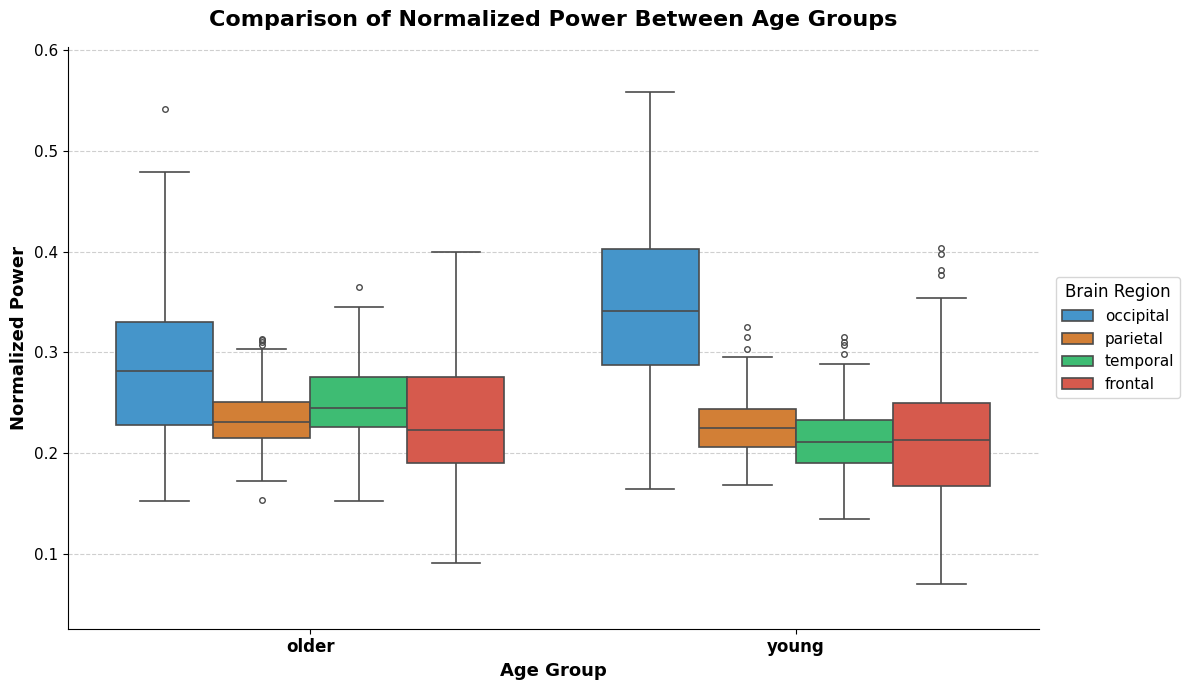

In [4]:
plt.figure(figsize=(12, 7))

ax = sns.boxplot(
    x='age_group', 
    y='normalized_power', 
    data=new_df_normalized, 
    hue='region',
    palette=['#3498db', '#e67e22', '#2ecc71', '#e74c3c'],
    linewidth=1.2,
    fliersize=4,
    saturation=0.8,
    width=0.8
)

plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)

plt.title('Comparison of Normalized Power Between Age Groups', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Age Group', fontsize=13, fontweight='bold')
plt.ylabel('Normalized Power', fontsize=13, fontweight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=11)

plt.legend(
    title='Brain Region', 
    title_fontsize=12,
    fontsize=11, 
    frameon=True,
    bbox_to_anchor=(1.01, 0.5), 
    loc='center left'
)

sns.despine()

y_min, y_max = plt.ylim()
plt.ylim(y_min - 0.02, y_max + 0.02)

plt.tight_layout()
plt.show()

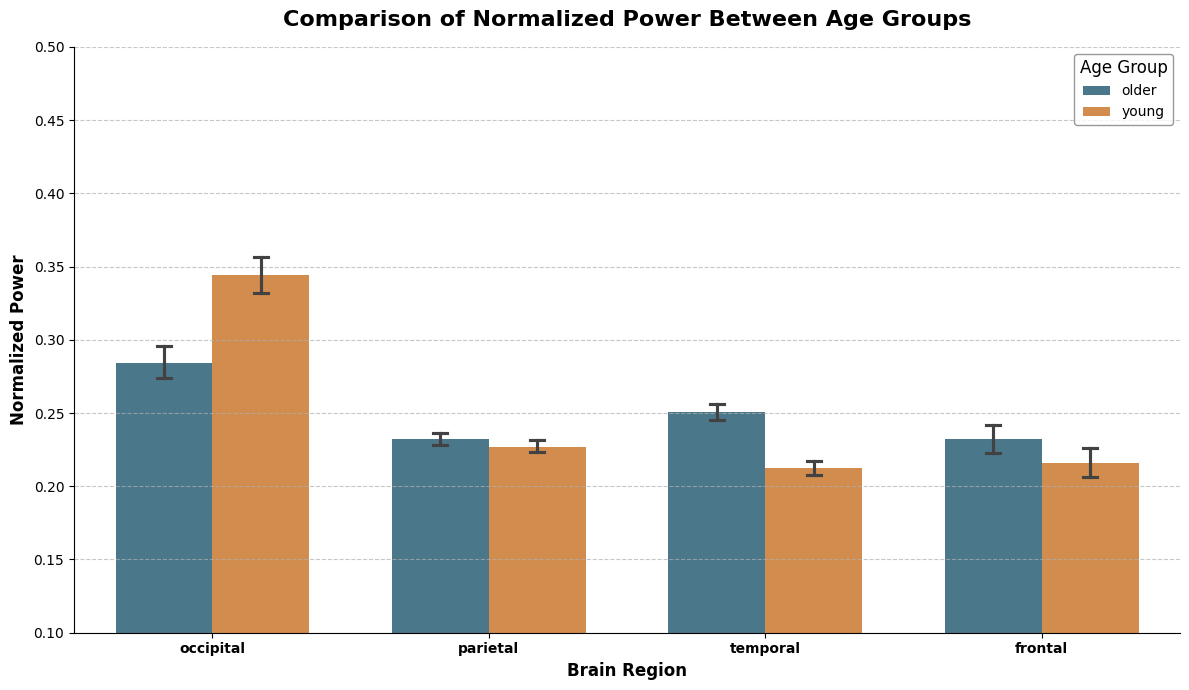

In [5]:
plt.figure(figsize=(12, 7))

ax = sns.barplot(
    x='region', 
    y='normalized_power', 
    data=new_df_normalized, 
    hue='age_group',
    palette=['#2b6d89', '#e67e22'], 
    errorbar=('ci', 95),
    capsize=0.1,
    width=0.7,
    alpha=0.9
)


plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

plt.title('Comparison of Normalized Power Between Age Groups', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Brain Region', fontsize=12, fontweight='bold')
plt.ylabel('Normalized Power', fontsize=12, fontweight='bold')


plt.xticks(fontweight='bold')


plt.ylim([0.10, 0.50])
plt.yticks(np.arange(0.10, 0.55, 0.05))


plt.legend(title='Age Group', title_fontsize=12, frameon=True, facecolor='white', edgecolor='gray')


plt.box(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

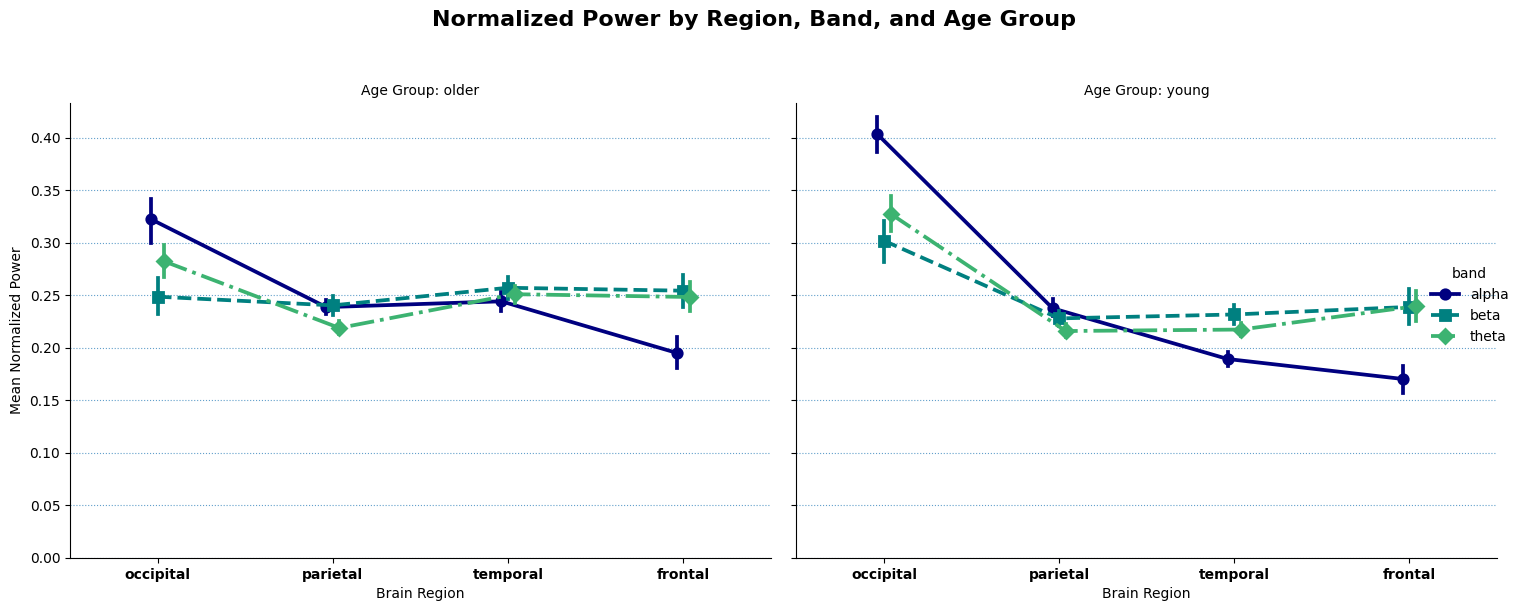

In [6]:
g = sns.catplot(
    data=new_df_normalized, 
    x='region',
    y='normalized_power',
    hue='band',
    col='age_group',
    kind='point',
    dodge=True,
    errorbar=('ci', 95),
    palette=['navy', 'teal', 'mediumseagreen'],
    height=6,
    aspect=1.2,
    markers=['o', 's', 'D'],
    linestyles=['-', '--', '-.']
)

g.set_axis_labels("Brain Region", "Mean Normalized Power")
g.set_titles("Age Group: {col_name}", fontsize=14)

g.set_xticklabels(rotation=0, fontweight='bold')

for ax in g.axes.flat:
    ax.set_ylim(0, None)
    
g.map(plt.grid, linestyle=':', alpha=0.7, axis='y')

plt.suptitle('Normalized Power by Region, Band, and Age Group', y=1.02, fontsize=16, fontweight='bold')

plt.tight_layout(pad=1.5)
plt.show()